In [1]:
from google.colab import files, drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install kaggle
!pip install numPy
!pip install tensorflow 
!pip install keras
!pip install pandas
!pip install -q chart_studio
!pip install torch

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [3]:
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
import os
from matplotlib.image import imread




import math
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

# plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from matplotlib.image import imread
import cv2

from sklearn.model_selection import ( KFold, train_test_split, 
                                    cross_validate, cross_val_score, GridSearchCV )
from sklearn.metrics import ( roc_curve, auc, precision_recall_curve, 
                             average_precision_score, ConfusionMatrixDisplay )
from mlxtend.plotting import plot_confusion_matrix

from random import choices
from functools import partial
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import re
# tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Dense, Flatten, Dropout, LSTM, 
                                     Bidirectional, Lambda, Reshape,
                                    GlobalAveragePooling2D, MaxPooling2D, 
                                     Conv2D) 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

# Suppress warnings 
import warnings
warnings.simplefilter(action='ignore')



In [4]:
test = pd.read_csv("/content/drive/MyDrive/Mole_AI/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Mole_AI/train.csv")

Inspect the data

In [5]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

In [6]:
train['target'].value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

In [7]:
train.head()

image_name  patient_id     sex  ...  diagnosis benign_malignant target
0  ISIC_2637011  IP_7279968    male  ...    unknown           benign      0
1  ISIC_0015719  IP_3075186  female  ...    unknown           benign      0
2  ISIC_0052212  IP_2842074  female  ...      nevus           benign      0
3  ISIC_0068279  IP_6890425  female  ...    unknown           benign      0
4  ISIC_0074268  IP_8723313  female  ...    unknown           benign      0

[5 rows x 8 columns]

In [8]:
print(os.listdir('drive/MyDrive/Mole_AI/train'))

KeyboardInterrupt: ignored

In [9]:
# Print out the contents of a folder
print(os.listdir())
# Set path from google drive
TEST_DIR  = "/content/drive/MyDrive/Mole_AI/test"
TRAIN_DIR = "/content/drive/MyDrive/Mole_AI/train/"
IMG_SIZE = (150, 150)

['.config', 'drive', 'sample_data']


In [10]:
# Function for plotting samples
def plot_samples(samples):  
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(32,16))
    for i in range(len(samples)):
        image = imread(samples[i])
        ax = axes[i//5][i%5]
        ax.imshow(image)
        if i<10: # first 10 files
            ax.set_title("Benign", fontsize=20)
        else:
            ax.set_title("Malignant", fontsize=20)
        ax.axis('off')

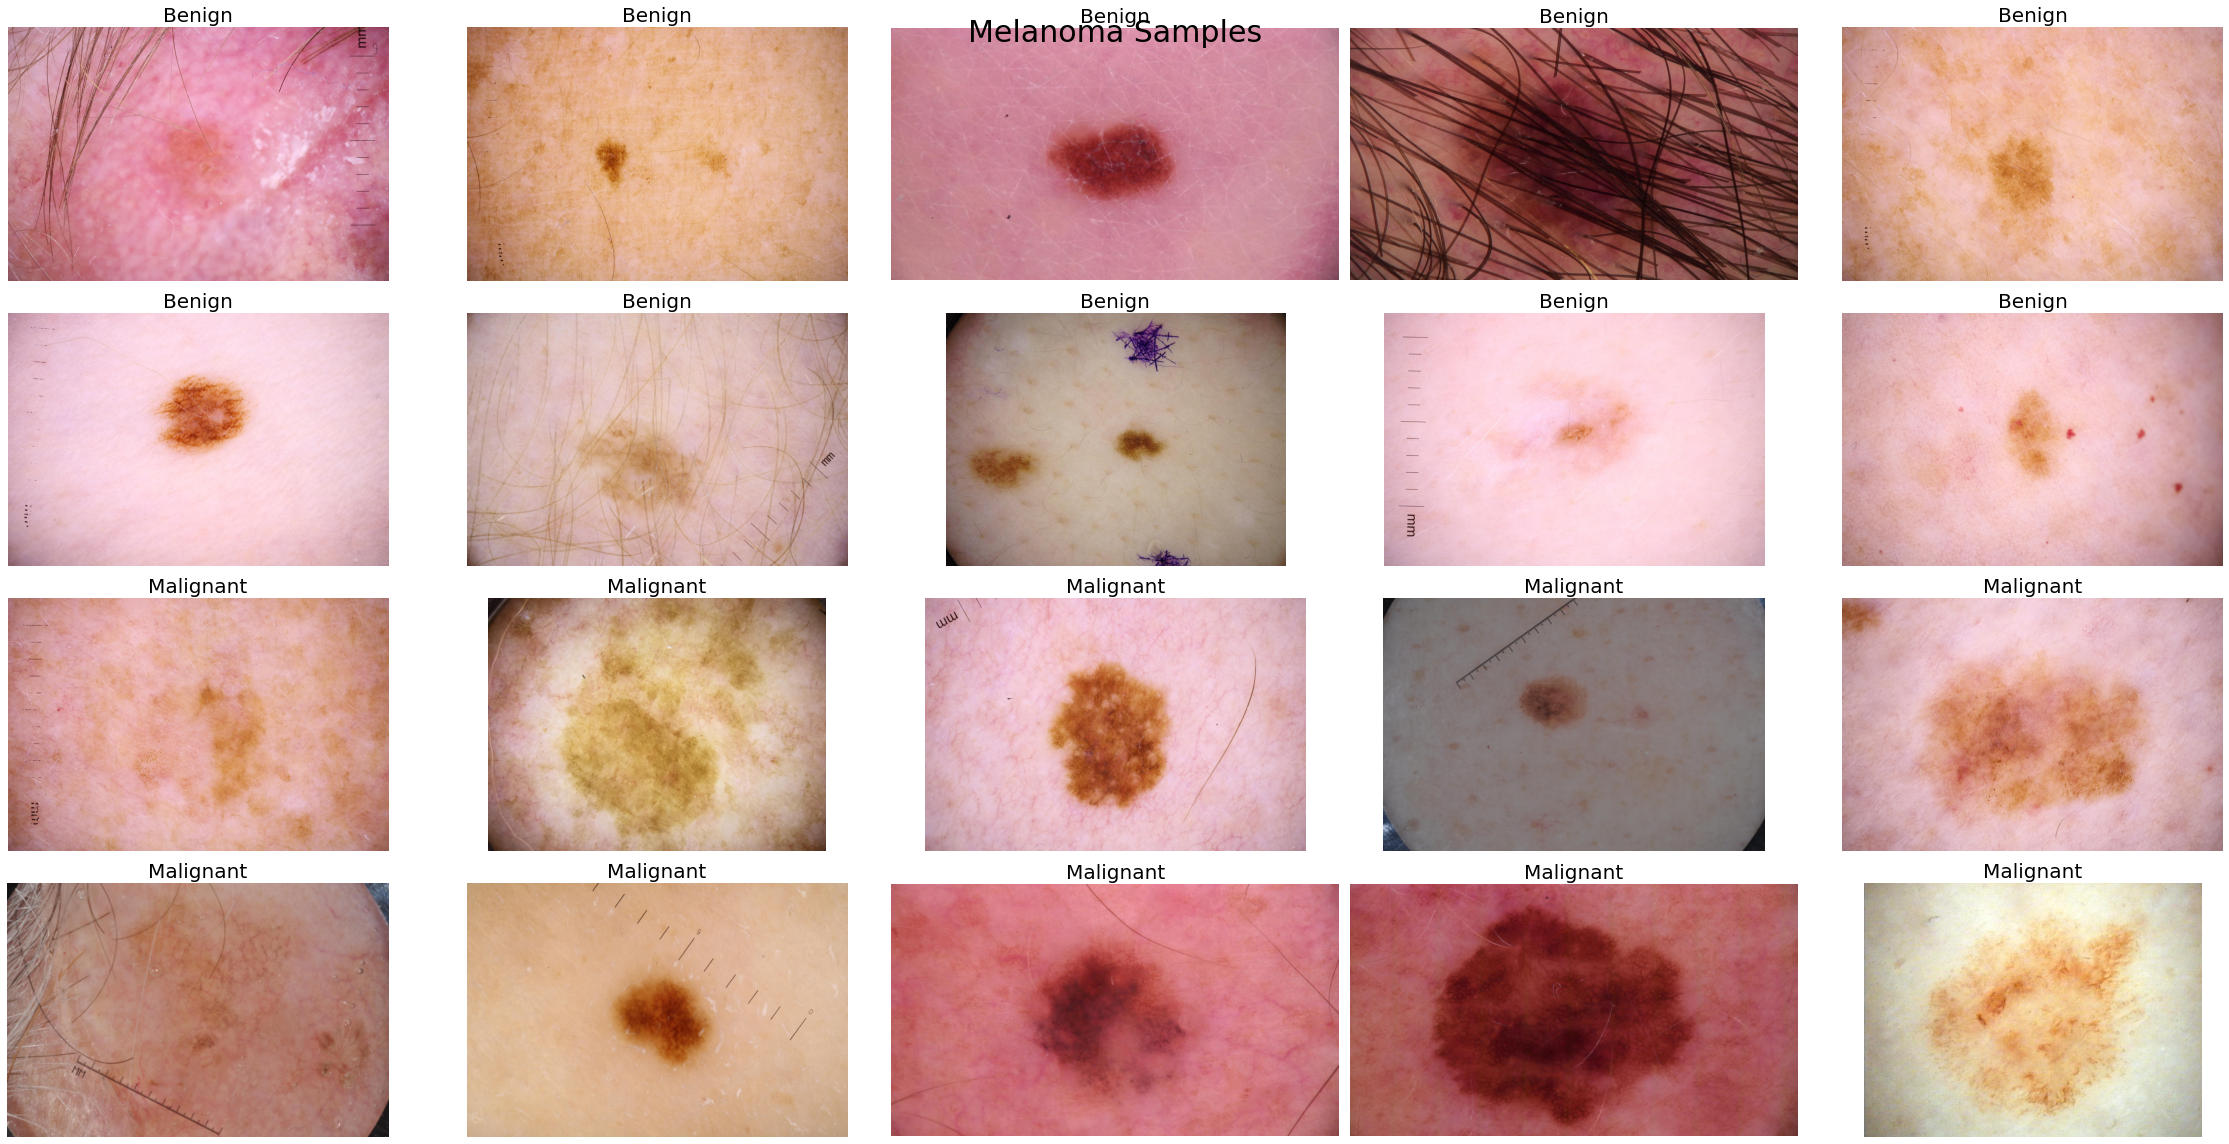

In [ ]:
# Load 10 of each type of image
sample_m = train[train['benign_malignant'] == 'benign']['image_name'][:10]
sample_b = train[train['benign_malignant'] == 'malignant']['image_name'][:10]

sample_img = []
# get benign filepaths
for i in sample_m:
  sample_img.append(TRAIN_DIR + '/' + i + '.jpg')
# get malignant filepaths 
for j in sample_b:
    sample_img.append(TRAIN_DIR + '/' + j + '.jpg' )
# plot the sample images
plot_samples(sample_img)
plt.suptitle('Melanoma Samples', fontsize=30)
plt.tight_layout()
plt.show()

In [ ]:
# Load images into memory in a different way
xmat = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed = 123, 
    image_size = (150,150),
)

yvec = train['target']

In [ ]:
# Load images into memory
def preprocessing():
  xmat = []
  img_set = train['image_name']
  img_set = img_set[:len(img_set)//32]


  for i, img in enumerate(img_set):
    path = TRAIN_DIR + '/' + img + '.jpg'

    if (i % 300) == 0:
      print(i, img)
    # load and resize
    x = img_to_array(load_img(path, target_size=(150, 150)))
    # i'd like to randomy rotate so hit with 0 < random angle < 360  
    xmat.append(x)

  # cast as NP array, shrink values to 0 - 1
  xmat = np.array(xmat)
  xmat = xmat.astype('float32')
  xmat /= 255

  return xmat



xmat = preprocessing()

0 ISIC_2637011
300 ISIC_0203233
600 ISIC_0284295
900 ISIC_0374029


In [ ]:
# Load the label vector 
yvec = train['target']
yvec = yvec[:len(yvec)//32]

print(len(yvec))
print(len(xmat))

1035
1035


In [ ]:
# define model
from keras.models import Sequential
from keras import optimizers
INPUT_SHAPE = (150, 150, 3)

# initialize that shit
model = Sequential()
model.add(Conv2D(16,(3,3), activation="relu", 
                input_shape=INPUT_SHAPE))
# yes layers that i definitely understand yes wooo convolute for me 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
# run it back
model.fit(xmat,yvec)


33/33 [==============================] - 36s 1s/step - loss: 0.0848 - accuracy: 0.9836
